<a href="https://colab.research.google.com/github/Kwannn666/AI-Interactive-Resume-Interview/blob/main/Q36134255_Final_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI 面試模擬系統：針對履歷與職缺生成互動問答

**重要補充 :**

**運行本專案需要 OpenAI API 金鑰設定**

為確保本 AI 面試模擬系統能完整運行所有功能，使用者需要設定一個有效的 OpenAI API 金鑰。請按照以下步驟操作：

1. 獲取金鑰： 如果您尚未擁有，請前往 OpenAI API Keys 頁面 登入並創建一個新的 Secret Key (sk-... 開頭)。

2. 在 Colab 中設定金鑰：

  a. 打開本專案的 Colab 連結。

  b. 在 Colab 介面左側，點擊鑰匙圖標 (Secrets / 秘密)。

  c. 點擊 + 新增密碼 (或 Add a new secret)。

  d. 在「名稱 (Name)」欄位中，輸入 OpenAI。（此名稱必須精確匹配，大小寫敏感）

  e. 在「值 (Value)」欄位中，貼上您從 OpenAI 獲取的 API 金鑰（例如 sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx）。

  f. 勾選下方的「在筆記本中顯示 (Notebook access)」選項。

4. 運行專案： 設定完成後，請依序執行 Colab 筆記本中的所有程式碼單元格。程式將自動從您的 Colab Secrets 中安全地載入金鑰。

**若未設定金鑰或金鑰無效，系統將無法調用 OpenAI 模型，面試對答及回饋功能將無法運作。**

操作流程介紹 :

1. 先執行 RAG.ipynb 將 一線公司RAG資料.docx 轉換成 faiss_IC_db  ，執行完後會產生
zip檔可供下載，下載解壓縮後得到 index.faiss，index.pkl
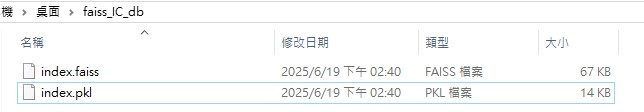

2. 在左側的檔案中創建 faiss_IC_db 資料夾 ，並且將 index.faiss，index.pkl 上傳到faiss_IC_db 資料夾裡面

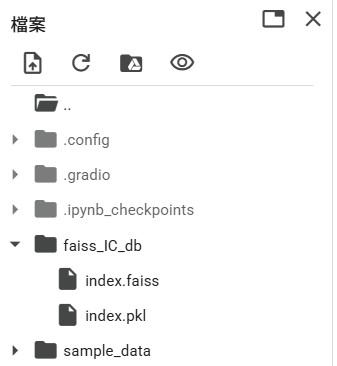

3. 執行主程式

4. Gradio 操作說明

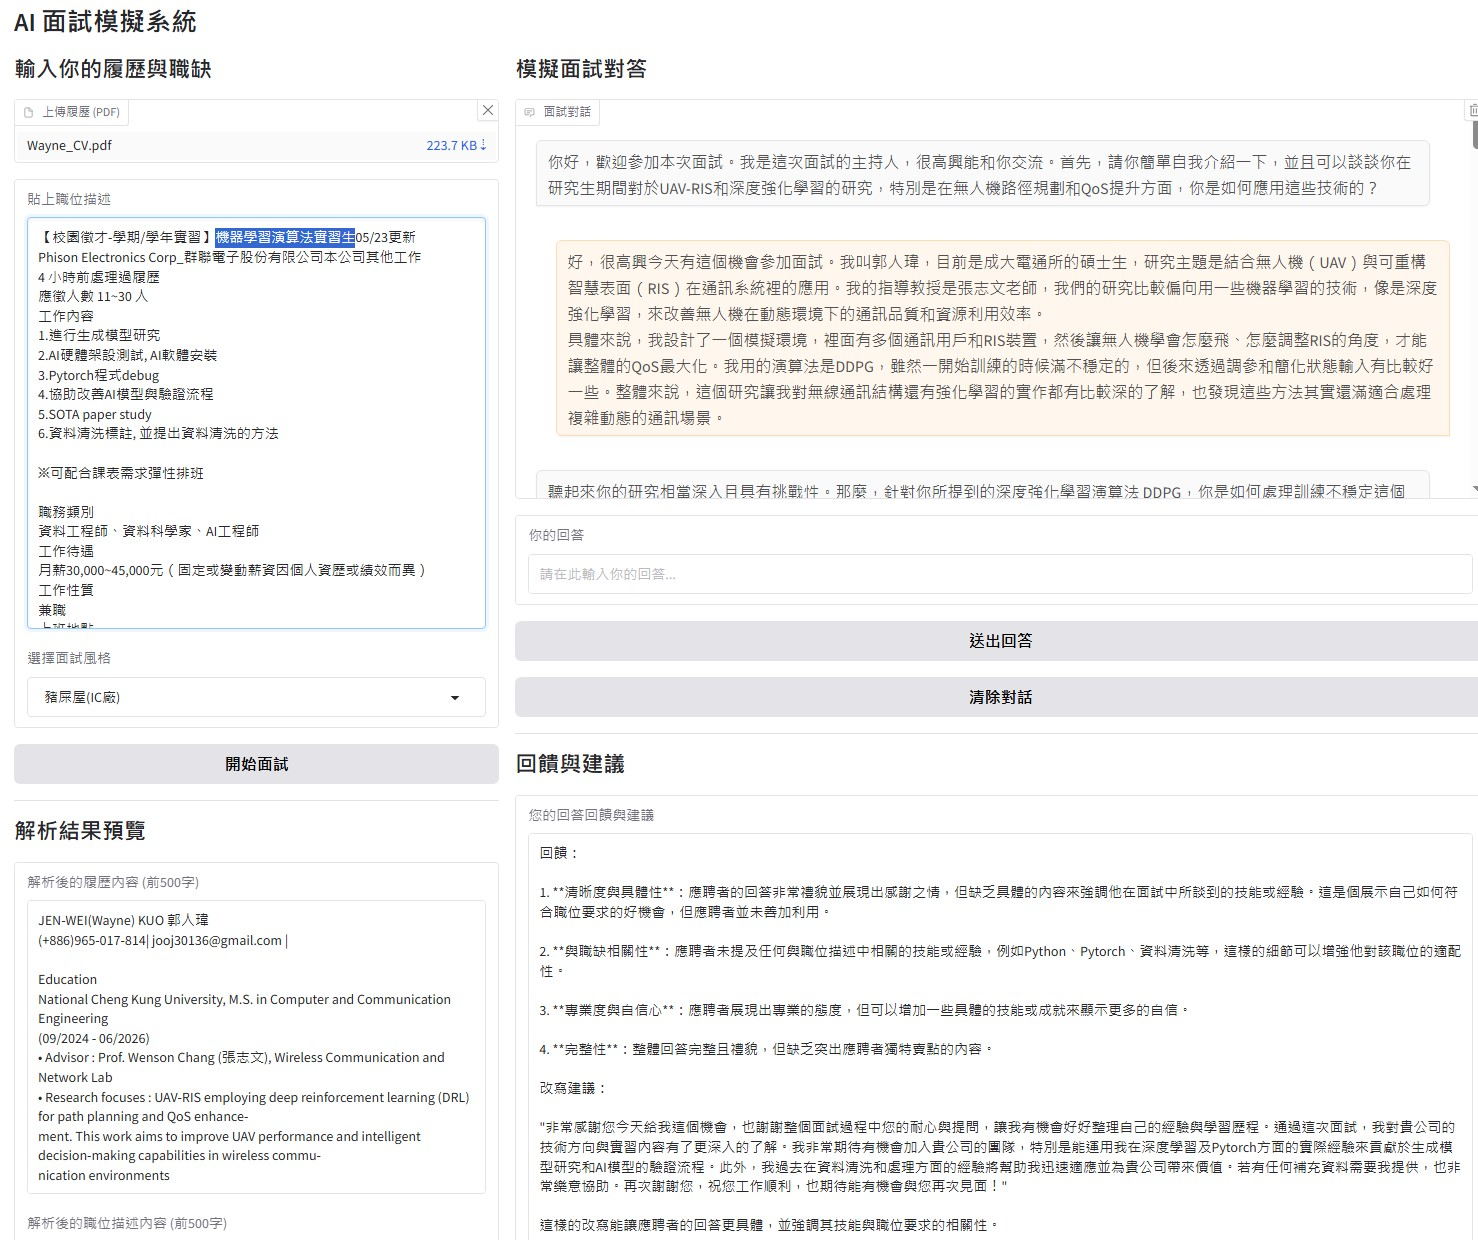

  1.先上傳履歷
  
  2.將網站上或信件中JD複製貼上到貼上職位描述欄位中

  3.選擇公司風格

  4.進行模擬面試

  5.生成回饋與建議

In [ ]:
!pip install -q faiss-cpu tiktoken langchain langchain-community openai gradio pypdf unstructured
import os
import gradio as gr
from getpass import getpass
from google.colab import userdata
import traceback
from langchain.chat_models import ChatOpenAI
from langchain.memory import ChatMessageHistory, ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# --- OpenAI API 金鑰 ---
try:
    api_key = userdata.get('OpenAI')
    os.environ['OPENAI_API_KEY'] = api_key
    print("OpenAI API 金鑰已透過 Colab userdata 安全載入並設定完成！")
except Exception as e:
    if "OPENAI_API_KEY" not in os.environ:
        os.environ["OPENAI_API_KEY"] = getpass("從 Colab Secrets 獲取金鑰失敗，請手動輸入您的 OpenAI API 金鑰: ")

# --- 變數和模型定義 ---
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.7)

parsed_resume_global = ""
parsed_job_description_global = ""

latest_question_for_feedback = ""
latest_answer_for_feedback = ""

interview_styles = interview_styles = {
"一般企業風格": "請以專業、客觀的方式提問，不偏向特定公司。",
"豬屎屋(IC廠)": "請以高度技術導向的方式提問，專注於應聘者的技術細節、實作經驗、以及對 IC設計、軟韌體開發技術相關領域的深度理解。問題應深入且具挑戰性。",
"系統廠": "請以系統整合與跨模組協作為核心進行提問，內容涵蓋軟硬體協同設計、產品開發流程、問題診斷與專案管理實務。",
"台積電": "請以高度嚴謹且製程導向的方式進行提問，聚焦於半導體製程技術、材料工程、良率分析、異常排除與細節管理等主題，問題需具備高度專業性與實務挑戰。",
"新創公司": "請以實作和成果導向為目標的方式提問，著重應聘者快速學習力、問題解決能力、產品落地經驗。問題應要具體，可能包含情境題或或要求闡述實際專案。",
"外商公司(如Google, NVIDIA)": "請結合開放性思維、行為導向與技術深度進行提問，探索應聘者的創新能力、系統設計邏輯、團隊合作經驗及英文表達能力，問題可包含高階演算法與設計挑戰。",
"傳統產業": "請以穩定性、責任感與實務能力為主軸進行提問，內容著重於應聘者的過往經驗、基礎技能熟練度、長期承諾及在穩定環境下的溝通協作表現。",
"壓力測試": "請設計問題來挑戰應聘者抗壓性、即時臨場應變能力和情緒管理的方式提問，問題可能較為尖銳或具有爭議性，但仍需保持專業。",

}

# --- 語意解析器 (Resume/Job Parser)) ---
def extract_text_from_pdf(pdf_path):
    """
    從 PDF 檔案中提取所有文本內容。
    """
    if pdf_path is None:
        return "請上傳您的履歷檔案。"
    try:
        loader = PyPDFLoader(pdf_path)
        documents = loader.load()
        text_content = ""
        for doc in documents:
            text_content += doc.page_content
        return text_content
    except Exception as e:
        return f"解析 PDF 時發生錯誤: {e}"

def escape_curly_braces(text):
    """
    轉義字符串中的單層花括號，使其不被視為模板變數。
    """
    escaped_text = ""
    i = 0
    while i < len(text):
        if text[i:i+2] == '{{':
            escaped_text += '{{'
            i += 2
        elif text[i:i+2] == '}}':
            escaped_text += '}}'
            i += 2
        elif text[i] == '{':
            escaped_text += '{{'
            i += 1
        elif text[i] == '}':
            escaped_text += '}}'
            i += 1
        else:
            escaped_text += text[i]
            i += 1
    return escaped_text

# --- RAG 檢索器 ---
retriever = None
try:
    embeddings_for_retrieval = OpenAIEmbeddings() # 載入時需要與創建時相同的 Embedding 模型
    retriever = FAISS.load_local("faiss_IC_db", embeddings_for_retrieval, allow_dangerous_deserialization=True).as_retriever(search_kwargs={"k": 3})
    print("RAG檢索器成功從 'faiss_IC_db' 載入。")
except Exception as e:
    print(f"RAG檢索器載入失敗。")
    traceback.print_exc()
    print("本模擬面試系統將在無RAG輔助模式下運行。")

# --- Prompt 組裝器 + 記憶模組) ---

# 面試對話 Prompt 模板 (包含風格調整和 RAG 整合)
def create_chat_prompt_template(style_name="一般企業風格"):
    escaped_resume = escape_curly_braces(parsed_resume_global)
    escaped_job_description = escape_curly_braces(parsed_job_description_global)
    style_instruction = interview_styles.get(style_name, interview_styles["一般企業風格"])

    retrieved_context = "無相關面試參考資訊。"
    if retriever:
        rag_query = f"關於 {parsed_job_description_global} 職位的面試技巧和 {style_name} 風格的常見問題及建議"
        try:
            retrieved_docs = retriever.invoke(rag_query)
            if retrieved_docs:
                retrieved_context = "\n".join([doc.page_content for doc in retrieved_docs])
        except Exception as e:
            print(f"RAG檢索發生錯誤。")
            traceback.print_exc()
            retrieved_context = "RAG檢索失敗，本模擬面試系統將在無RAG輔助模式下運行。"

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""
你是一位經驗豐富的 AI 面試官。
你的任務是根據提供的履歷和職位描述，模擬真實的面試過程，全程使用繁體中文以及英文。
{style_instruction}

以下是應聘者的履歷內容：
<RESUME>
{escaped_resume}
</RESUME>

以下是職位描述：
<JOB_DESCRIPTION>
{escaped_job_description}
</JOB_DESCRIPTION>

以下是面試策略或專業知識的參考資訊（請你**盡量**利用這些資訊來提問和評估。如果這些資訊不相關而或不足，請依賴你本身的專業知識和判斷）：
<REFERENCE_CONTEXT>
{retrieved_context}
</REFERENCE_CONTEXT>

請記住，每次只提出一個問題。
"""),
            MessagesPlaceholder(variable_name="history"),
            ("human", "{input}"),
        ]
    )
    return prompt

# --- 第一次問題生成 Prompt 模板 ---
def create_initial_interview_prompt_for_first_question(resume_content, job_description_content, style_name="一般企業風格"):
    style_instruction = interview_styles.get(style_name, interview_styles["一般企業風格"])

    retrieved_context = "無相關面試參考資訊。"
    if retriever:
        rag_query = f"關於 {job_description_content} 職位的面試開場問題和 {style_name} 風格的建議"
        try:
            retrieved_docs = retriever.invoke(rag_query)
            if retrieved_docs:
                retrieved_context = "\n".join([doc.page_content for doc in retrieved_docs])
        except Exception as e:
            print(f"RAG 檢索在 create_initial_interview_prompt_for_first_question 中發生錯誤: {e}")
            traceback.print_exc()
            retrieved_context = "RAG 檢索失敗，將依賴內部知識。"

    prompt = f"""
你是一位經驗豐富的 AI 面試官。
你的任務是根據提供的履歷和職位描述，模擬真實的面試過程，全程使用繁體中文以及英文。
{style_instruction}

以下是應聘者的履歷內容：
<RESUME>
{resume_content}
</RESUME>

以下是職位描述：
<JOB_DESCRIPTION>
{job_description_content}
</JOB_DESCRIPTION>

以下是面試策略或專業知識的參考資訊（請你**盡量**結合這些資訊來提問。如果資訊不適用，請依賴你本身的知識）：
<REFERENCE_CONTEXT>
{retrieved_context}
</REFERENCE_CONTEXT>

面試開始。請你先進行一個簡短的開場白（例如：你好，歡迎參加本次面試），然後提出第一個問題。
通常第一個問題會是請應聘者進行自我介紹，或是針對履歷中某個顯著特點提問。
請記住，你的回答必須包含開場白和第一個問題，並且只提出一個問題。
"""
    return prompt

# --- 回饋結果生成 Prompt 模板 (關鍵評分模組) ---
feedback_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", f"""你是一位資深的人資顧問，專精於面試技巧與溝通分析，全程使用繁體中文以及英文。
你的任務是審核應聘者在模擬面試中的回答，提供針對職場新鮮人系統建設性的回饋和優化性的改寫建議。
請根據以下準則進行評估：
1. **清晰度與具體性**：回答是否清晰、易懂，是否有具體的例子或數據支持。
2. **與職缺相關性**：回答是否與職位要求和應聘者履歷內容相關。
3. **專業度與自信心**：回答是否展現專業的態度和自信，而非誇大自信。
4. **完整性**：回答是否完整回答了問題的所有面向。

請一針見血的指出回答中模糊或不具體的點，並提供從職場新鮮的角度提出至少一個具體的改寫建議，使其更具說服力。
請直接給出回饋和建議，不需要再次提問。

應聘者的履歷內容：
<RESUME>
{{resume}}
</RESUME>

職位描述：
<JOB_DESCRIPTION>
{{job_description}}
</JOB_DESCRIPTION>

應聘者之前的問題是：
<QUESTION>
{{question}}
</QUESTION>

應聘者的回答是：
<ANSWER>
{{answer}}
</ANSWER>

以下是相關面試策略或專業知識的參考資訊（請你**盡量**結合這些資訊來提供回饋，但如果資訊不適用，請依賴你本身的知識）：
<REFERENCE_CONTEXT>
{{retrieved_feedback_context}}
</REFERENCE_CONTEXT>

請針對以上回答給出回饋與建議：
"""),
        ("human", "請根據上述資訊，提供應聘者回答的回饋與改寫建議。")
    ]
)
feedback_chain = feedback_prompt_template | llm

store = {}

def get_session_history(session_id: str) -> ChatMessageHistory:
    if session_id not in store:
        store[session_id] = ConversationBufferMemory(return_messages=True)
    return store[session_id].chat_memory

interview_chain_runnable = None
with_message_history = None

# --- Gradio 介面相關函數 ---
def start_interview(resume_file, job_description_text, selected_style):
    """
    處理初始輸入並開始面試。
    """
    global parsed_resume_global, parsed_job_description_global, store, with_message_history, interview_chain_runnable
    global latest_question_for_feedback, latest_answer_for_feedback
    resume_content = extract_text_from_pdf(resume_file.name) if resume_file else "未上傳履歷。"
    job_description_content = job_description_text if job_description_text else "未輸入職位描述。"
    parsed_resume_global = resume_content
    parsed_job_description_global = job_description_content
    store.clear()
    latest_question_for_feedback = ""
    latest_answer_for_feedback = ""
    interview_chain_runnable = create_chat_prompt_template(style_name=selected_style) | llm
    with_message_history = RunnableWithMessageHistory(
        interview_chain_runnable,
        get_session_history,
        input_messages_key="input",
        history_messages_key="history",
        verbose=True
    )
    initial_question_prompt = create_initial_interview_prompt_for_first_question(
        resume_content=parsed_resume_global,
        job_description_content=parsed_job_description_global,
        style_name=selected_style
    )
    first_question_response = llm.invoke(initial_question_prompt)
    first_question = first_question_response.content
    session_id = "default_session"
    history_memory_obj = get_session_history(session_id)
    history_memory_obj.add_ai_message(first_question)
    chat_history_display = [(None, first_question)]
    return (
        resume_content[:500],
        job_description_content[:500],
        chat_history_display,
        gr.update(value="", interactive=True),
        gr.update(interactive=True),
        gr.update(value="", interactive=False),
        gr.update(interactive=False)
    )

def chat_with_ai(user_input, chat_history_display, current_style):
    """
    處理應聘者的回答並生成 AI 的追問。
    """
    global with_message_history, interview_chain_runnable, parsed_resume_global, parsed_job_description_global
    global latest_question_for_feedback, latest_answer_for_feedback

    if parsed_resume_global == "" and parsed_job_description_global == "":
        chat_history_display.append((user_input, "請先上傳履歷和職缺並點擊「開始面試」按鈕，才能開始對話。"))
        return "", chat_history_display, gr.update(value="", interactive=False), gr.update(interactive=False)

    session_id = "default_session"
    interview_chain_runnable = create_chat_prompt_template(style_name=current_style) | llm
    with_message_history = RunnableWithMessageHistory(
        interview_chain_runnable,
        get_session_history,
        input_messages_key="input",
        history_messages_key="history",
        verbose=True
    )

    last_ai_question_before_user_input = chat_history_display[-1][1] if chat_history_display and chat_history_display[-1][1] else ""

    response = with_message_history.invoke(
        {"input": user_input},
        config={"configurable": {"session_id": session_id}}
    )
    ai_response = response.content

    latest_question_for_feedback = last_ai_question_before_user_input
    latest_answer_for_feedback = user_input

    chat_history_display.append((user_input, ai_response))

    return (
        "", chat_history_display,
        gr.update(value="", interactive=False),
        gr.update(interactive=True)
    )

def get_feedback_for_last_answer():
    """
    生成針對應聘者最近一次回答的回饋。
    """
    global feedback_chain, parsed_resume_global, parsed_job_description_global, latest_question_for_feedback, latest_answer_for_feedback

    if not latest_question_for_feedback or not latest_answer_for_feedback or \
       parsed_resume_global == "" or parsed_job_description_global == "":
        return "請先完成一次面試對答 (即提問與回答)，並確保已上傳履歷和職缺，才能獲取回饋。"

    try:

        feedback_rag_query = f"如何評估應聘者關於「{latest_question_for_feedback}」的回答「{latest_answer_for_feedback}」"
        retrieved_feedback_docs = retriever.invoke(feedback_rag_query) if retriever else []
        retrieved_feedback_context = "\n".join([doc.page_content for doc in retrieved_feedback_docs]) if retrieved_feedback_docs else "無相關評估參考資訊。"

        feedback_response = feedback_chain.invoke({
            "resume": parsed_resume_global,
            "job_description": parsed_job_description_global,
            "question": latest_question_for_feedback,
            "answer": latest_answer_for_feedback,
            "retrieved_feedback_context": retrieved_feedback_context
        })
        return feedback_response.content
    except Exception as e:
        print(f"生成回饋時發生錯誤: {e}")
        traceback.print_exc()
        return f"生成回饋時發生錯誤: {e}"

# --- 模擬面試對答生成介面 Gradio 界面定義 ---
with gr.Blocks() as demo:
    gr.Markdown("# AI 面試模擬系統")
# --- 使用者輸入 (User Input) (履歷(PDF)+JD(文字)) ---
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("## 輸入你的履歷與職缺")
            resume_input = gr.File(label="上傳履歷 (PDF)", file_types=[".pdf"])
            job_desc_input = gr.Textbox(label="貼上職位描述", lines=8, placeholder="請在此貼上職位描述文字...")

            style_selector = gr.Dropdown(
                label="選擇面試風格",
                choices=list(interview_styles.keys()),
                value="一般企業風格",
                interactive=True
            )

            start_interview_btn = gr.Button("開始面試")
            gr.Markdown("---")
            gr.Markdown("## 解析結果預覽")
            resume_output_preview = gr.Textbox(label="解析後的履歷內容 (前500字)", lines=5, interactive=False)
            job_desc_output_preview = gr.Textbox(label="解析後的職位描述內容 (前500字)", lines=5, interactive=False)


        with gr.Column(scale=2):
            gr.Markdown("## 模擬面試對答")
            chatbot = gr.Chatbot(label="面試對話", height=400)
            user_msg = gr.Textbox(label="你的回答", placeholder="請在此輸入你的回答...", interactive=False)
            send_btn = gr.Button("送出回答", interactive=False)
            clear_btn = gr.Button("清除對話")

            gr.Markdown("---")
            gr.Markdown("## 回饋與建議")
            feedback_output = gr.Textbox(label="您的回答回饋與建議", lines=10, interactive=False)
            get_feedback_btn = gr.Button("獲取回答回饋", interactive=False)

    start_interview_btn.click(
        fn=start_interview,
        inputs=[resume_input, job_desc_input, style_selector],
        outputs=[resume_output_preview, job_desc_output_preview, chatbot, user_msg, send_btn, feedback_output, get_feedback_btn]
    )

    user_msg.submit(
        fn=chat_with_ai,
        inputs=[user_msg, chatbot, style_selector],
        outputs=[user_msg, chatbot, feedback_output, get_feedback_btn]
    )
    send_btn.click(
        fn=chat_with_ai,
        inputs=[user_msg, chatbot, style_selector],
        outputs=[user_msg, chatbot, feedback_output, get_feedback_btn]
    )

    get_feedback_btn.click(
        fn=get_feedback_for_last_answer,
        inputs=[],
        outputs=[feedback_output]
    )

    clear_btn.click(
        lambda: ([], "", "", gr.update(interactive=False), gr.update(interactive=False), gr.update(value="", interactive=False), gr.update(interactive=False)),
        outputs=[chatbot, user_msg, resume_output_preview, user_msg, send_btn, feedback_output, get_feedback_btn]
    )

demo.launch(debug=True, share=True)

OpenAI API 金鑰已透過 Colab userdata 安全載入並設定完成！


/tmp/ipython-input-1-4084709341.py:26: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.7)
/tmp/ipython-input-1-4084709341.py:90: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings_for_retrieval = OpenAIEmbeddings() # 載入時需要與創建時相同的 Embedding 模型


RAG檢索器成功從 'faiss_IC_db' 載入。


/tmp/ipython-input-1-4084709341.py:384: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="面試對話", height=400)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d45ae876df13dc238a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-1-4084709341.py:240: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  store[session_id] = ConversationBufferMemory(return_messages=True)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d45ae876df13dc238a.gradio.live
